<a href="https://colab.research.google.com/github/1ee1hee/Deep_Learning/blob/main/CNN_Image_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN small datasets 학습
- 학습할 Data의 개수가 많지 않을 때 CNN을 통한 모형 학습이 어려울 수 있음
    - 딥러닝은 많은 수의 데이터를 통해 feature engineering 과정 없이 원하는 문제를 해결할 수 있다 => **Point: 많은 데이터수**
- Data가 많지 않아 CNN 학습에 어려움이 있을 때 사용 가능한 방법
    - Data augmentation 활용
        - 원본 이미지의 색, 각도 등 약간 씩 변형한 이미지들을 추가로 만들어 데이터 수를 늘림
    - Pre-trained network 활용
        - 매우 큰 데이터셋으로 미리 Training한 모델의 파라미터를 가져와 문제에 맞게 모델을 재보정하여 사용
        - 성능이 좋은 학습된 모델을 사용하므로 적은 데이터에도 좋은 성능을 낼 수 있음

## Data for cats vs. dogs
- 2013년 Kaggle의 computer vision competition data 활용 https://www.kaggle.com/c/dogs-vs-cats/data
- 개와 고양이를 구분하기 위한 문제로 각 12,500개의 이미지를 포함
- Medium-resolution color JPEGs
- 25000장의 사진 중 4000장의 cats/dogs 사진(2000 cats, 2000 dogs) 만을 사용하여 학습하여 좋은 모형을 만들어 낼 수 있을까?
    - 학습: 2000, 검증: 1000, 테스트: 1000
    
![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

### 하이퍼파라미터 정의

In [1]:
LEARNING_RATE = 0.001
N_EPOCH = 200
N_BATCH = 100

### 모델 구현 및 학습

- Input: $224 \times 224$ 픽셀의 RGB layer
- Output: cat or dog (binary classification)  
- ImageDataGenerator를 이용해 파일시스템에 저장된 이미지 데이터셋을 학습시킨다.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import random

random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [12]:
# 모델 생성
def get_model():
    model = keras.Sequential()

    model.add(layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu', input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D(padding = 'same'))

    model.add(layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(layers.MaxPooling2D(padding = 'same'))

    model.add(layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(layers.MaxPooling2D(padding = 'same'))

    model.add(layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(layers.MaxPooling2D(padding = 'same'))

    model.add(layers.Conv2D(filters = 256, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(layers.MaxPooling2D(padding = 'same'))

    model.add(layers.Conv2D(filters = 256, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(layers.MaxPooling2D(padding = 'same'))

    model.add(layers.Flatten())
    model.add(layers.Dropout(rate = 0.5))
    model.add(layers.Dense(units = 1, activation = 'sigmoid', name = 'binary_classification_output'))

    model.compile(optimizer = optimizers.Adam(learning_rate = LEARNING_RATE),
                  loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

### ImageDataGenerator 생성

In [13]:
# 데이터셋 디렉토리 경로

trainset_dir = '/content/drive/Othercomputers/mymy/GDrive/data/cats_and_dogs_small/train'
valset_dir = '/content/drive/Othercomputers/mymy/GDrive/data/cats_and_dogs_small/validation'
testset_dir = '/content/drive/Othercomputers/mymy/GDrive/data/cats_and_dogs_small/test'

In [14]:
# image augmentation 미적용
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

# Iterator 생성 -> raw data 파일과 연결
train_iter = train_datagen.flow_from_directory(trainset_dir,
                                               target_size = (244, 244),
                                               class_mode = 'binary',
                                               batch_size = N_BATCH)
val_iter = val_datagen.flow_from_directory(valset_dir, target_size=(224, 224), class_mode = 'binary', batch_size = N_BATCH)
test_iter = test_datagen.flow_from_directory(testset_dir, target_size=(224, 244), class_mode = 'binary', batch_size = N_BATCH )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
train_iter.class_indices

{'cats': 0, 'dogs': 1}

In [16]:
v = next(train_iter)
print(type(v))
print(v[0].shape)
print(v[1].shape)

<class 'tuple'>
(100, 244, 244, 3)
(100,)


In [17]:
v[1][:10]

array([0., 0., 1., 0., 0., 0., 0., 0., 1., 1.], dtype=float32)

### Model Training(학습)

In [18]:
import os

g_drive_path = '/content/drive/MyDrive/github'
save_dir_path = os.path.join(g_drive_path, 'saved_model', 'cat_dog_model_no_aug')
os.makedirs(save_dir_path, exist_ok = True)

save_weight_path = os.path.join(save_dir_path, 'ckpt')

mc_callback = keras.callbacks.ModelCheckpoint(filepath = save_weight_path,
                                              save_weights_only = True,
                                              save_best_only = True,
                                              monitor = 'val_loss', verbose = 1)
es_callback = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=10, verbose = 1)

In [20]:
model = get_model()
hist = model.fit(train_iter, epochs = N_EPOCH,
                 steps_per_epoch = len(train_iter),
                 validation_data = val_iter,
                 validation_steps = len(val_iter),
                 callbacks = [mc_callback, es_callback])

Epoch 1/200
20/20 [==============================] - ETA: 0s - loss: 0.6943 - accuracy: 0.4860
Epoch 1: val_loss did not improve from 0.49515
20/20 [==============================] - 20s 897ms/step - loss: 0.6943 - accuracy: 0.4860 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/200
20/20 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.5195
Epoch 2: val_loss did not improve from 0.49515
20/20 [==============================] - 18s 929ms/step - loss: 0.6935 - accuracy: 0.5195 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 3/200
20/20 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.4990
Epoch 3: val_loss did not improve from 0.49515
20/20 [==============================] - 18s 889ms/step - loss: 0.6935 - accuracy: 0.4990 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 4/200
20/20 [==============================] - ETA: 0s - loss: 0.6911 - accuracy: 0.5450
Epoch 4: val_loss did not improve from 0.49515
20/20 [=============================

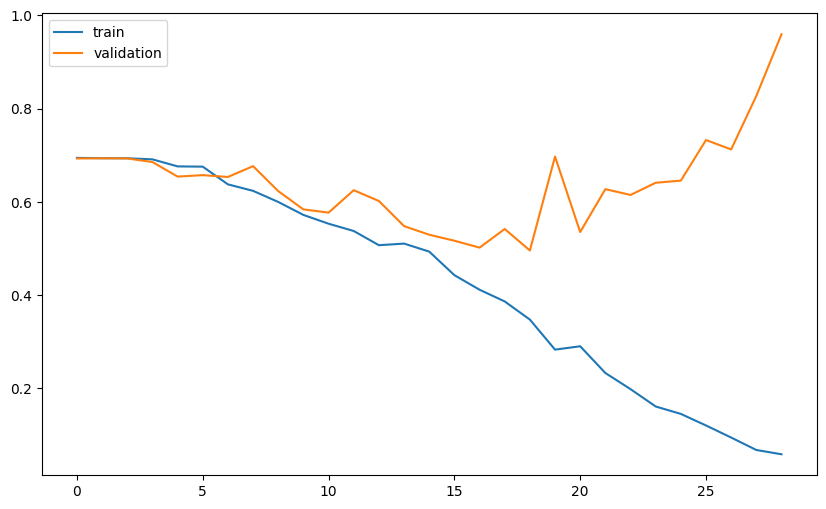

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(hist.epoch, hist.history['loss'], label='train')
plt.plot(hist.epoch, hist.history['val_loss'], label='validation')
plt.legend()
plt.show()

### 저장된 모델 조회

In [22]:
# 모델 생성
saved_model1 = get_model()
saved_model1.evaluate(test_iter)

10/10 [==============================] - 431s 47s/step - loss: 0.6942 - accuracy: 0.5000


[0.6942421793937683, 0.5]

In [23]:
# 생성된 모델에 저장된 파라미터 덮어씌우기
saved_model1.load_weights(save_weight_path)
saved_model1.evaluate(test_iter)

10/10 [==============================] - 6s 602ms/step - loss: 0.4846 - accuracy: 0.7720


[0.48457878828048706, 0.7720000147819519]

### 새로운 데이터 추론

In [24]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_preprocessing(image_path):
    raw_img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(raw_img)
    img_array = img_array[np.newaxis, ...]
    img_array = img_array.astype('float32')/255
    return img_array

In [27]:
new_img_path = '/content/drive/MyDrive/github/dog.jpg'

new_X = load_preprocessing(new_img_path)

pred = saved_model1.predict(new_X)
print(pred)
print(np.where(pred>=0.5, '개', '고양이'))


1/1 [==============================] - 0s 19ms/step
[[0.81972915]]
[['개']]


## Image data augmentation 사용
- 학습 이미지의 수가 적어서 overfitting이 발생할 가능성을 줄이기 위해 기존 훈련 데이터로 부터 이비지 변환을 통해 이미지(데이터)를 늘리는 작업을 Image augmentation이라 함
- train_set에만 적용, validation, test set에는 적용하지 않는다(rescaling만 함)

### ImageDatagenerator 생성

In [28]:
# 데이터셋 디렉토리 경로

trainset_dir = '/content/drive/Othercomputers/mymy/GDrive/data/cats_and_dogs_small/train'
valset_dir = '/content/drive/Othercomputers/mymy/GDrive/data/cats_and_dogs_small/validation'
testset_dir = '/content/drive/Othercomputers/mymy/GDrive/data/cats_and_dogs_small/test'

In [29]:
# train ImageDataGenerator 생성 => Image Augmentation 설정(train set에만 설정)
train_datagen2 = ImageDataGenerator(rescale = 1./255,
                                    rotation_range = 40,
                                    width_shift_range = 0.2,
                                    height_shift_range = 0.2,
                                    shear_range = 5,
                                    zoom_range = 0.2,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    brightness_range = (0.5, 1.5),
                                    fill_mode = 'constant'
                                    )
val_datagen2 = ImageDataGenerator(rescale = 1./255)
test_datagen2 = ImageDataGenerator(rescale = 1./255)

In [30]:
train_iter2 = train_datagen2.flow_from_directory(trainset_dir, target_size=(224, 224), class_mode = 'binary', batch_size = N_BATCH)
val_iter2 = val_datagen2.flow_from_directory(valset_dir, target_size=(224, 224), class_mode = 'binary', batch_size = N_BATCH)
test_iter2 = test_datagen2.flow_from_directory(testset_dir, target_size=(224, 224), class_mode = 'binary', batch_size = N_BATCH)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### 모델 생성, 컴파일, 학습

In [31]:
import os

g_drive_path = '/content/drive/MyDrive/github'
save_dir_path = os.path.join(g_drive_path, 'saved_model', 'cat_dog_model_aug')
mc_callback2 = keras.callbacks.ModelCheckpoint(save_dir_path, save_best_only = True, monitor = 'val_loss', verbose = 1)
es_callback2 = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1)

In [32]:
model2 = get_model()
hist2 = model2.fit(train_iter2, epochs = N_EPOCH,
                   steps_per_epoch = len(train_iter2),
                   validation_data = val_iter2,
                   validation_steps = len(val_iter2),
                   callbacks = [mc_callback2, es_callback2]
                   )

Epoch 1/200
20/20 [==============================] - ETA: 0s - loss: 0.6958 - accuracy: 0.4810
Epoch 1: val_loss improved from inf to 0.69309, saving model to /content/drive/MyDrive/github/saved_model/cat_dog_model_aug
20/20 [==============================] - 48s 2s/step - loss: 0.6958 - accuracy: 0.4810 - val_loss: 0.6931 - val_accuracy: 0.5110
Epoch 2/200
20/20 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.4990
Epoch 2: val_loss did not improve from 0.69309
20/20 [==============================] - 41s 2s/step - loss: 0.6934 - accuracy: 0.4990 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/200
20/20 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.4775
Epoch 3: val_loss did not improve from 0.69309
20/20 [==============================] - 41s 2s/step - loss: 0.6933 - accuracy: 0.4775 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/200
20/20 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.5200
Epoch 4: val_lo

In [33]:
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import load_img, img_to_array

saved_model2 = models.load_model('/content/drive/MyDrive/github/saved_model/cat_dog_model_aug')

### 새로운 데이터 추론

In [34]:
import numpy as np

def load_preprocessing_image(path):
    raw_img = load_img(path, target_size = (224, 224))
    img_array = img_to_array(raw_img)
    img_array = img_array[np.newaxis, ...]
    img_array = img_array.astype('float32')/255
    return img_array

In [35]:
img_path = '/content/drive/MyDrive/github/cat.jpg'
data = load_preprocessing_image(img_path)
pred = saved_model2.predict(data)
pred_label = np.where(pred[0] >= 0.5, '개', '고양이')
print(pred[0], pred_label)

1/1 [==============================] - 0s 92ms/step
[0.49979398] ['고양이']
